# Notebook to examine rag evaluation results

In [1]:
# Imports
import sys
import pandas as pd
import numpy as np
sys.path.append("../dev/")
sys.path.append("../src/")
import time
import seaborn as sns
import matplotlib.pyplot as plt
from csv_helpers import get_csv_files_from_dir


### Analyse and plot the pool results - of all entangled parameter permutations

In [2]:
# Function definition
# Look at the eval results files, especially the mean correctness
import dask.dataframe as dd
# Loop over all eval results files
# Get column names which are the config parameters and the mean correctness or some other metric
def create_df_mean_correctness(dataset,evaluator, directory):
    columns = [
        "quExp",
        "rerank",
        "cExp",
        "backRev",
        "numRefLim",
        "select",
        "evaluator",
    ] + ["MeanCorrectness"]
    mean_correctness_df = pd.DataFrame(columns=columns)
    # Get file names
    eval_results_file_names = get_csv_files_from_dir(directory)
    # Iterate over all eval results files
    for filename in eval_results_file_names[:]:  # Iterate over all eval results files
        # Filter files: Only look at files with quExp1_rerank1_cExp*_backRevFalse_numRef4
        # first_file = f"{eval_results_dir}/{eval_results_file_names[1]}"  # Slice for dev
        file = eval_results_dir + "/" + filename  # Slice for dev
    
        # Read eval results from CSV
        eval_results_df = dd.read_csv(file)
        # Show the first 5 rows
        
        correctness_values = eval_results_df["Correct"].dropna()
        correctness_values = correctness_values.compute(engine="python")
    
        #print(f"Correctness values: {correctness_values}")
    
        mean = sum(correctness_values) / len(correctness_values)
        
        # Project the values to be between 0 and 1
        mean_scaled = (mean - min(correctness_values)) / (max(correctness_values) - min(correctness_values))

        #print(f"Mean correctness: {mean}")
        # Append the correctness values to the list
        config = filename.split("_")
        #print(f" Config: {config}")
        mean_correctness_df = pd.concat(
            [
                mean_correctness_df,
                pd.DataFrame(
                    [
                        {
                            "quExp": config[0].replace("quExp", ""),
                            "rerank": config[1].replace("rerank", ""),
                            "cExp": config[2].replace("cExp", ""),
                            "backRev": config[3].replace("backRev", ""),
                            "numRefLim": config[4].replace("numRefLim", ""),
                            "select": config[-2],
                            "evaluator": config[-1].replace(".csv", ""),
                            "MeanCorrectness": mean_scaled,
                        }
                    ]
                ),
            ]
        )
    return mean_correctness_df


def create_df_mean_correctness_single_param(dataset,evaluator, directory):
    columns = [
        "quExp",
        "rerank",
        "cExp",
        "backRev",
        "numRefLim",
        "llm",
        "select",
        "evaluator",
    ] + ["MeanCorrectness"]
    mean_correctness_df = pd.DataFrame(columns=columns)
    # Get file names
    eval_results_file_names = get_csv_files_from_dir(directory)
    # Iterate over all eval results files
    for filename in eval_results_file_names[:]:  # Iterate over all eval results files
        # Filter files: Only look at files with quExp1_rerank1_cExp*_backRevFalse_numRef4
        # first_file = f"{eval_results_dir}/{eval_results_file_names[1]}"  # Slice for dev
        file = eval_results_dir + "/" + filename  # Slice for dev
    
        # Read eval results from CSV
        eval_results_df = dd.read_csv(file)
        # Show the first 5 rows
        
        correctness_values = eval_results_df["Correct"].dropna()
        correctness_values = correctness_values.compute(engine="python")
    
        #print(f"Correctness values: {correctness_values}")
    
        mean = sum(correctness_values) / len(correctness_values)
        
        # Project the values to be between 0 and 1
        mean_scaled = (mean - min(correctness_values)) / (max(correctness_values) - min(correctness_values))

        #print(f"Mean correctness: {mean}")
        # Append the correctness values to the list
        config = filename.split("_")
        #print(f" Config: {config}")
        mean_correctness_df = pd.concat(
            [
                mean_correctness_df,
                pd.DataFrame(
                    [
                        {
                            "quExp": config[0].replace("quExp", ""),
                            "rerank": config[1].replace("rerank", ""),
                            "cExp": config[2].replace("cExp", ""),
                            "backRev": config[3].replace("backRev", ""),
                            "numRefLim": config[4].replace("numRefLim", ""),
                            "llm": config[5].replace(":latest", ""),
                            "select": config[-2],
                            "evaluator": config[-1].replace(".csv", ""),
                            "MeanCorrectness": mean_scaled,
                        }
                    ]
                ),
            ]
        )
    return mean_correctness_df

### Analyse parameter significance

In [ ]:
# Extract results wo get insights on parameter significance
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
sns.set_theme(style="whitegrid", font_scale=1.5)
sns.set_palette("colorblind")  # Suitable for colorblind readers
sns.color_palette("muted")    # Balanced colors
sns.set_context("paper")


# Set configuration
parameter = "pool" # pool, quExp, rerank, cExp, backRev, numRefLim
evaluator = "ROUGE-1" # llm-judge, ROUGE-1
dataset = "miniWiki" # miniBiosQA, miniWiki
eval_results_dir = f"../100_rows_pipe_results/{dataset}/{parameter}/{evaluator}"

# Create the dataframe
mean_correctness_df = create_df_mean_correctness(dataset,evaluator, eval_results_dir)
mean_correctness_df = mean_correctness_df[mean_correctness_df["select"] == "correctness"]
# mean_correctness_df = mean_correctness_df[mean_correctness_df["rerank"].isin(["True", "rrf"])] 
mean_correctness_df.sort_values(by="MeanCorrectness", ascending=False)
print(f"Dataset: {dataset}, \nEvaluator: {evaluator}, \nParameter: {parameter}")

# Initialize pandas df to store p values and respective method
p_values_df = pd.DataFrame(columns=["Method", "p-value", "f-value"], index=None)
# Loop over all rag methods

for rag_method in ["Number Sources", "Query Expansion", "Re-rank", "Context Expansion"]:
    # Calcualate the p and f values
    # Shorten the dataframe name
    df = mean_correctness_df
    #Get unique values of the rag method column 
    method_variables = df[rag_method].unique()
    print(f"Unique values of {rag_method}: {method_variables}")
    # One-way ANOVA: Test if the means of 'x' differ across categories in 'a'
    groups = [df[df[rag_method] == variable]['Mean Correctness'] for variable in method_variables]
    f_stat, p_value = stats.f_oneway(*groups)
    print(f"ANOVA result for {rag_method}: F-statistic = {f_stat}, p-value = {p_value}")
    # Append the p and f values to the dataframe
    p_values_df = pd.concat(
        [
            p_values_df,
            pd.DataFrame(
                [
                    {
                        "Method": rag_method,
                        "p-value": p_value,
                        "f-value": f_stat
                    }
                ]
            ),
        ]
    )

   
    # Make a histplot with respect to the rag method
    hist = sns.histplot(data=mean_correctness_df, x="Mean Correctness", hue=rag_method, kde=True)
    
    # Change labels of rag method categories
    if rag_method == "Re-rank":
        new_labels = ["Off","Semantic","RRF"]
        for t, label in zip(hist.legend_.texts, new_labels):
            t.set_text(label)  # Update the legend labels

    if rag_method == "Context Expansion":
        new_labels = ["Off","On"]
        for t, label in zip(hist.legend_.texts, new_labels):
            t.set_text(label)  # Update the legend labels
        
    # plt.title(f"Mean Correctness distribution with {evaluator} {dataset}")
    plt.savefig(f"../plots/{dataset}_{evaluator}_{parameter}_{rag_method}_histplot.pdf",format="pdf")
    plt.show()

## Save the p values to a csv file
p_values_df.to_csv(f"../plots/{dataset}_{evaluator}_{parameter}_p_values.csv")
with pd.option_context("max_colwidth", 100):
    p_values_df.to_latex(f"../tables/{dataset}_{evaluator}_{parameter}_p_values.tex",index=False)
   

### In Depth Analysis of single parameter - LLM, Rerank, Context Expansion

/tmp/ipykernel_556733/2030367571.py:103: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mean_correctness_df = pd.concat(


   quExp rerank   cExp backRev numRefLim          llm       select  evaluator  \
0      1  False  False   False         1          all          all  llm-judge   
0      1  False  False   False         1  correctness  correctness  llm-judge   
0      1  False  False   False         2          all          all  llm-judge   
0      1  False  False   False         2  correctness  correctness  llm-judge   
0      1  False  False   False         3          all          all  llm-judge   
..   ...    ...    ...     ...       ...          ...          ...        ...   
0      3    rrf   True   False         3  correctness  correctness  llm-judge   
0      3    rrf   True   False         4          all          all  llm-judge   
0      3    rrf   True   False         4  correctness  correctness  llm-judge   
0      3    rrf   True   False         5  correctness  correctness  llm-judge   
0      3    rrf   True   False         6  correctness  correctness  llm-judge   

    MeanCorrectness  
0    

/tmp/ipykernel_556733/3797675634.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=mean_correctness_df, x="cExp", y="MeanCorrectness",palette="colorblind")


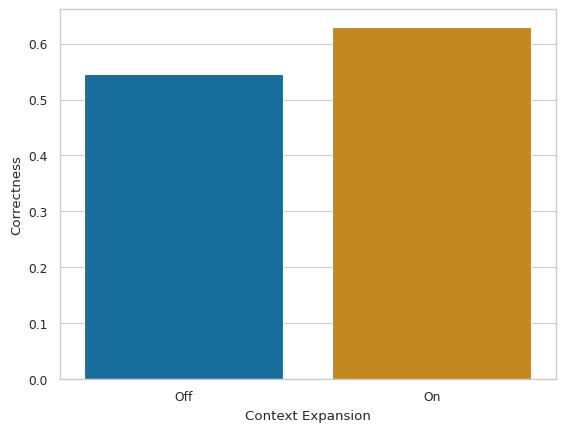

In [49]:
# Extract results wo get insights on parameter significance
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
sns.set_theme(style="whitegrid", font_scale=1.5)
sns.set_palette("colorblind")  # Suitable for colorblind readers
sns.set_context("paper")


# Set configuration
#parameter = "rerank" # pool, quExp, rerank, cExp, backRev, numRefLim, select "pool" for grid search results
#evaluator = "ROUGE-1" # llm-judge, ROUGE-1
#dataset = "miniBiosQA" # miniBiosQA, miniWiki
#eval_results_dir = f"../eval_results/{dataset}/{parameter}/{evaluator}"

parameter = "pool" # pool, quExp, rerank, cExp, backRev, numRefLim, select "pool" for grid search results
evaluator = "llm-judge" # llm-judge, ROUGE-1
dataset = "miniBiosQA" # miniBiosQA, miniWiki
eval_results_dir = f"../100_rows_eval_results/{dataset}/{parameter}/{evaluator}"

# Create the dataframe
mean_correctness_df = create_df_mean_correctness_single_param(dataset,evaluator,eval_results_dir)
print(mean_correctness_df)
# Filter select is correctness
mean_correctness_df = mean_correctness_df[mean_correctness_df["select"] == "correctness"]
# Filter number of source 
mean_correctness_df = mean_correctness_df[mean_correctness_df["numRefLim"].isin(["3"])]
# Filter quExp
mean_correctness_df = mean_correctness_df[mean_correctness_df["quExp"] == "1"]
# Filter cExp 
mean_correctness_df = mean_correctness_df[mean_correctness_df["rerank"] == "False"]
print(mean_correctness_df)
# Make bar plot with respect to the LLMs
sns.barplot(data=mean_correctness_df, x="cExp", y="MeanCorrectness",palette="colorblind")
plt.xlabel("Context Expansion")
#cat_labels = ["Off", "Semantic","RRF"]
cat_labels = ["Off","On"]
plt.xticks(ticks=range(len(cat_labels)), labels=cat_labels)
# set y label
plt.ylabel("Correctness")
#plt.ylim(0.8,1)
filename = f"../plots/{dataset}_{evaluator}_cExp_barplot.pdf"
plt.savefig(filename,format="pdf")
print(f"Dataset: {dataset}, \nEvaluator: {evaluator}, \nParameter: {parameter}")
print(f"Written to file: {filename}")

### Make large table of correctnes values for all parameter configurations 

In [12]:
# Extract results wo get insights on parameter significance
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
sns.set_theme(style="whitegrid")
sns.set_context("paper")
sns.set_context("talk")
sns.set_context("notebook")

# Set configuration
parameter = "pool" # pool, quExp, rerank, cExp, backRev, numRefLim
evaluator = "ROUGE-1" # llm-judge, ROUGE-1
dataset = "miniBiosQA" # miniBiosQA, miniWiki
eval_results_dir = f"../100_rows_eval_results/{dataset}/{parameter}/{evaluator}"

# Create the dataframe
mean_correctness_df = create_df_mean_correctness(dataset,evaluator, eval_results_dir)
# Rename the columns of the dataframe for plotting
mean_correctness_df.rename(columns={
    "quExp": "Query Expansion",
    "rerank": "Re-rank",
    "cExp": "Context Expansion",
    "backRev": "Backward Revision",
    "numRefLim": "Number Sources",
    "select": "Selection Method",
    "evaluator": "Evaluator",
    "MeanCorrectness": "Mean Correctness"
}, inplace=True)

# Define custom names for the values in the 'Category' column
rerank_names = {
    'False': 'Off',
    'True': 'Semantic',
    'rrf': 'RRF'
}
cExp_names = {
    'False': 'Off',
    'True': 'On',
}

queExp_names = {
    '1': 'Off',
    '2': '2',
    '3': '3',
}

# Replace the values in the re-rank, qExp and cExp columns with the custom names
mean_correctness_df['Re-rank'] = mean_correctness_df['Re-rank'].map(rerank_names)
mean_correctness_df['Context Expansion'] = mean_correctness_df['Context Expansion'].map(cExp_names)
mean_correctness_df['Query Expansion'] = mean_correctness_df['Query Expansion'].map(queExp_names)

mean_correctness_df = mean_correctness_df[mean_correctness_df["Selection Method"] == "correctness"]
mean_correctness_df = mean_correctness_df[mean_correctness_df["Backward Revision"] == "False"]
mean_correctness_df = mean_correctness_df[['Query Expansion', 'Re-rank', 'Context Expansion', 'Number Sources', 'Mean Correctness']]
mean_correctness_df = mean_correctness_df.sort_values(by="Mean Correctness", ascending=False)
table = mean_correctness_df.to_latex(f"../tables/{dataset}_{evaluator}_{parameter}_full_correctness_table.tex",index=False)


/tmp/ipykernel_556733/2030367571.py:43: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  mean_correctness_df = pd.concat(


## Evaluate gold passages if given

In [ ]:
def create_df_goldPassages(dataset,directory):
    # Column names with the config params and the matches and sum of matches
    columns = [
        "quExp",
        "rerank",
        "cExp",
        "backRev",
        "numRefLim",
    ] + ["matches", "sum_matches"]
    context_id_matches = pd.DataFrame(columns=columns)
    # Get file names
    eval_results_file_names = get_csv_files_from_dir(directory)
    # Iterate over all eval results files
    for filename in eval_results_file_names[:]:  # Iterate over all eval results files
        # Filter files: Only look at files with quExp1_rerank1_cExp*_backRevFalse_numRef4
        # first_file = f"{eval_results_dir}/{eval_results_file_names[1]}"  # Slice for dev
        file = directory + "/" + filename  # Slice for dev
    
        # Read eval results from CSV
        df = pd.read_csv(file)
        # Keep only the 'contexts_ids' and 'goldPassages' columns
        # Calcualte matches between the ids in the two columns
      
        # Account for a row containint no list but a single int
        if isinstance(df["contexts_ids"][0], int):
            df["contexts_ids"] = df["contexts_ids"].apply(lambda row: [row])
        else:
            df["contexts_ids"] = df["contexts_ids"].apply(
                lambda row: [int(row)] if isinstance(row, int) else list(map(int, row.split(", "))) if isinstance(row, str) and row else []
            )
       
        df["goldPassages"] = df["goldPassages"].apply(
            lambda row: list(map(int, row.split(", "))) if row else []
        )
        
        # Calculate matches between the ids in the two columns
        matches = df.apply(
            lambda row: len(set(row["contexts_ids"]).intersection(row["goldPassages"])),
            axis=1,
        )
        # Calculate the recall , i.e. the number of matches divided by the number of relevant documents. Note that the number of relevant documents is the number of gold passages and varies per question
        recall = df.apply(
            lambda row: len(set(row["contexts_ids"]).intersection(row["goldPassages"])) / len(row["goldPassages"]) if len(row["goldPassages"]) > 0 else 0,
            axis=1,
        )
        
        numberGoldPassages = df.apply(
            lambda row: len(row["goldPassages"]),
            axis=1,
        )


        # Add the matches to the DataFrame
        df = df[["contexts_ids", "goldPassages"]]
        # df["matches"] = matches

        # Write the eval results to a csv file
        # eval_results_dir = "./parallel_100_rows_eval"
        # Add param settings and matches to the DataFrame
        # print(f"Param settings: {param_settings}")
        # print(f"Matches \n: {matches.array}")
        # Add the param settings and matches row per row to the DataFrame
        config = filename.split("_")
        context_id_matches = pd.concat(
            [
                context_id_matches,
                pd.DataFrame(
                    [
                        {
                            "quExp": config[0].replace("quExp", ""),
                            "rerank": config[1].replace("rerank", ""),
                            "cExp": config[2].replace("cExp", ""),
                            "backRev":  config[3].replace("backRev", ""),
                            "numRefLim": config[4].replace("numRefLim", ""),
                            "matches": matches.array,
                            "sum_matches": matches.sum(),
                            "nGoldPassages": numberGoldPassages.sum(),
                            "recall@k": recall.sum() / len(recall) if len(recall) > 0 else 0
                        }
                    ]
                ),
            ]
        )
    return context_id_matches


# Set style
sns.set_theme(style="whitegrid", font_scale=1.5)
sns.set_palette("colorblind")  # Suitable for colorblind readers
sns.color_palette("muted")    # Balanced colors
sns.set_context("paper")

# Set configuration
parameter = "rerank" # pool, quExp, rerank, cExp, backRev, numRefLim
dataset = "miniBiosQA" # miniBiosQA, miniWiki
maxSources = 5
#eval_results_dir = f"../parallel_100_rows_eval/{dataset}/{evaluator}"
pipe_results_dir = f"../pipe_results/{dataset}/{parameter}"

# Create the dataframe
context_matches_df = create_df_goldPassages(dataset, pipe_results_dir)
print(context_matches_df)



# Select rows where numRefLim is 5 and cExp is False
context_matches_df = context_matches_df[(context_matches_df["numRefLim"] == str(maxSources))  & (context_matches_df["quExp"] == "1")]
print(context_matches_df)
context_matches_df = context_matches_df[["rerank", "sum_matches","nGoldPassages","recall@k"]]
plt.figure(figsize=(10, 6))
# Make a bar plot with the sum of matches

print(context_matches_df)
sns.set_palette("colorblind") 
sns.barplot(data=context_matches_df, x="rerank", y="sum_matches",palette="colorblind").set(xlabel="")
rerank_labels = ["Off", "Semantic", "RRF"]
plt.xticks(ticks=range(len(rerank_labels)), labels=rerank_labels)
plt.savefig(f"../plots/{dataset}_rerank_sum_matches.pdf",format="pdf")
#plt.title(f"Sum of gold resource matches {dataset}")

# Make a bar plot with the recall
plt.figure(figsize=(10, 6))
sns.barplot(data=context_matches_df, x="rerank", y="recall@k",palette="colorblind")
rerank_labels = ["Off", "Semantic", "RRF"]
plt.xticks(ticks=range(len(rerank_labels)), labels=rerank_labels)
plt.ylim(0.0,0.5)
plt.savefig(f"../plots/{dataset}_rerank_recall5.pdf",format="pdf")

In [ ]:
# Get answer and ground_truth of rag elements
from evaluate import ROUGE
from pprint import pprint
answer = "yes"
ground_truth = "yes, however the weather is not good and aspiring to be a good person is not easy. Whis leads to some people being bad."

print(f"Answer: {answer}")
print(f"Ground truth: {ground_truth}")
rouge = ROUGE(answer, ground_truth)
pprint(rouge)
print("\n")


In [ ]:
# Look at filenames 
# Get eval results file names
eval_results_dir = "../eval_results/LLMs/miniWiki"
eval_results_file_names = get_csv_files_from_dir(eval_results_dir)

# Loop over all eval results files and output the filenames with an index in the dir
for i, filename in enumerate(eval_results_file_names[:]):  # Iterate over all eval results files
    print(f"{i}: {filename}")

### RAG Triad

In [51]:
def add_triad_column(df,combination): 
    ## Add a column with the triad sum based on the desired combination
    if combination == "average":
        # Sum the CR, Faithfulness and AR values and put in a new colum called triad sum
        df["CR"] = df["CR"].apply(lambda x: sum(map(float, x.strip('[]').split())) / len(x.strip('[]').split()) if pd.notna(x) else np.nan)
        df["Faithfulness"] = df["Faithfulness"].apply(lambda x: sum(map(float, x.strip('[]').split())) / len(x.strip('[]').split()) if pd.notna(x) else np.nan)
        df["TriadSum"] = (df["CR"] + df["Faithfulness"] + df["AR"]) / 3

    # Take the first element of context relevance, faithfulness and answer relevance
    if combination == "first":
        print(f"Linear combination: {combination}")
        df["CR"] = df["CR"].apply(lambda x: float(x.strip('[]').split()[0]))
        df["Faithfulness"] = df["Faithfulness"].apply(lambda x: float(x.strip('[]').split()[0]))
        df["TriadSum"] = ( df["CR"]* 2 + df["Faithfulness"]* 2 + df["AR"] ) / 3
    
    if combination == "high":
        print(f"Linear combination: {combination}")
        df["CR"] = df["CR"].apply(lambda x: max(map(float, x.strip('[]').split())))
        df["Faithfulness"] = df["Faithfulness"].apply(lambda x: max(map(float, x.strip('[]').split())))
        df["TriadSum"] = ( df["CR"] + df["Faithfulness"] + df["AR"] ) / 3
    return df


File: ../eval_results/triad/quExp1_rerankTrue_cExpFalse_backRevFalse_numRefLim5_mixtral:latest_all_llm-judge_gemma2-eval.csv
Linear combination: high
              TriadSum        CR  Faithfulness        AR   Correct
TriadSum      1.000000  0.757960      0.769012  0.840871  0.567082
CR            0.757960  1.000000      0.409561  0.467293  0.384719
Faithfulness  0.769012  0.409561      1.000000  0.440146  0.364219
AR            0.840871  0.467293      0.440146  1.000000  0.568495
Correct       0.567082  0.384719      0.364219  0.568495  1.000000


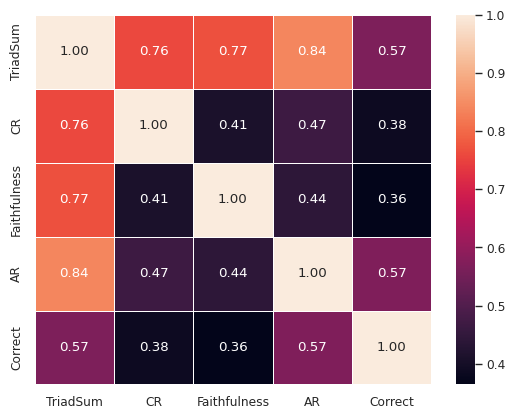

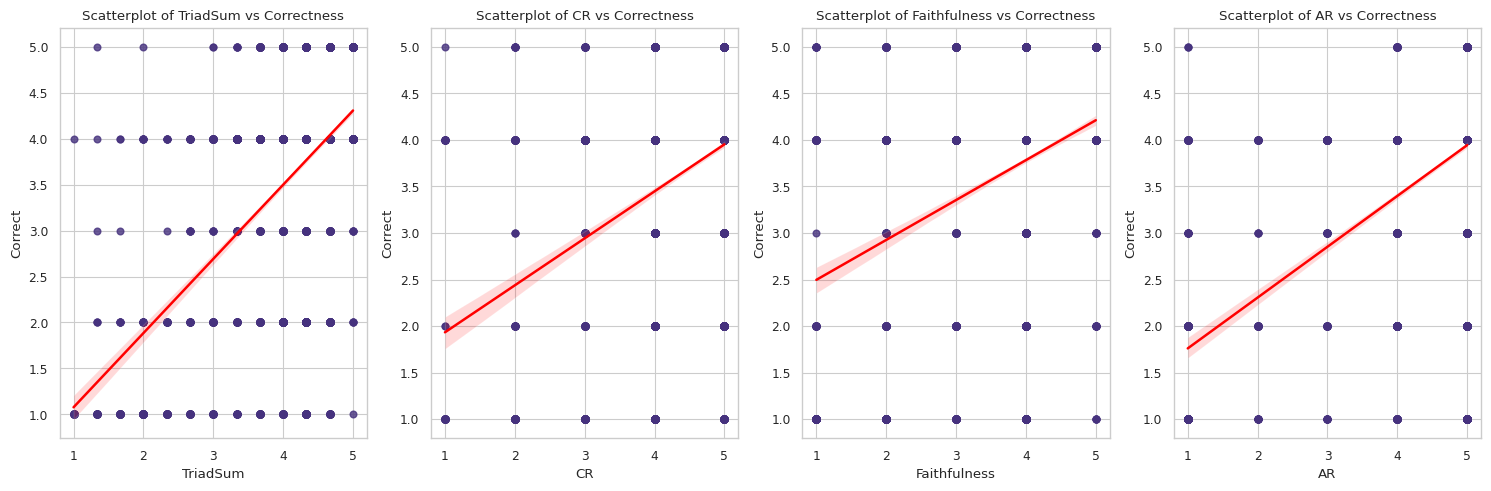

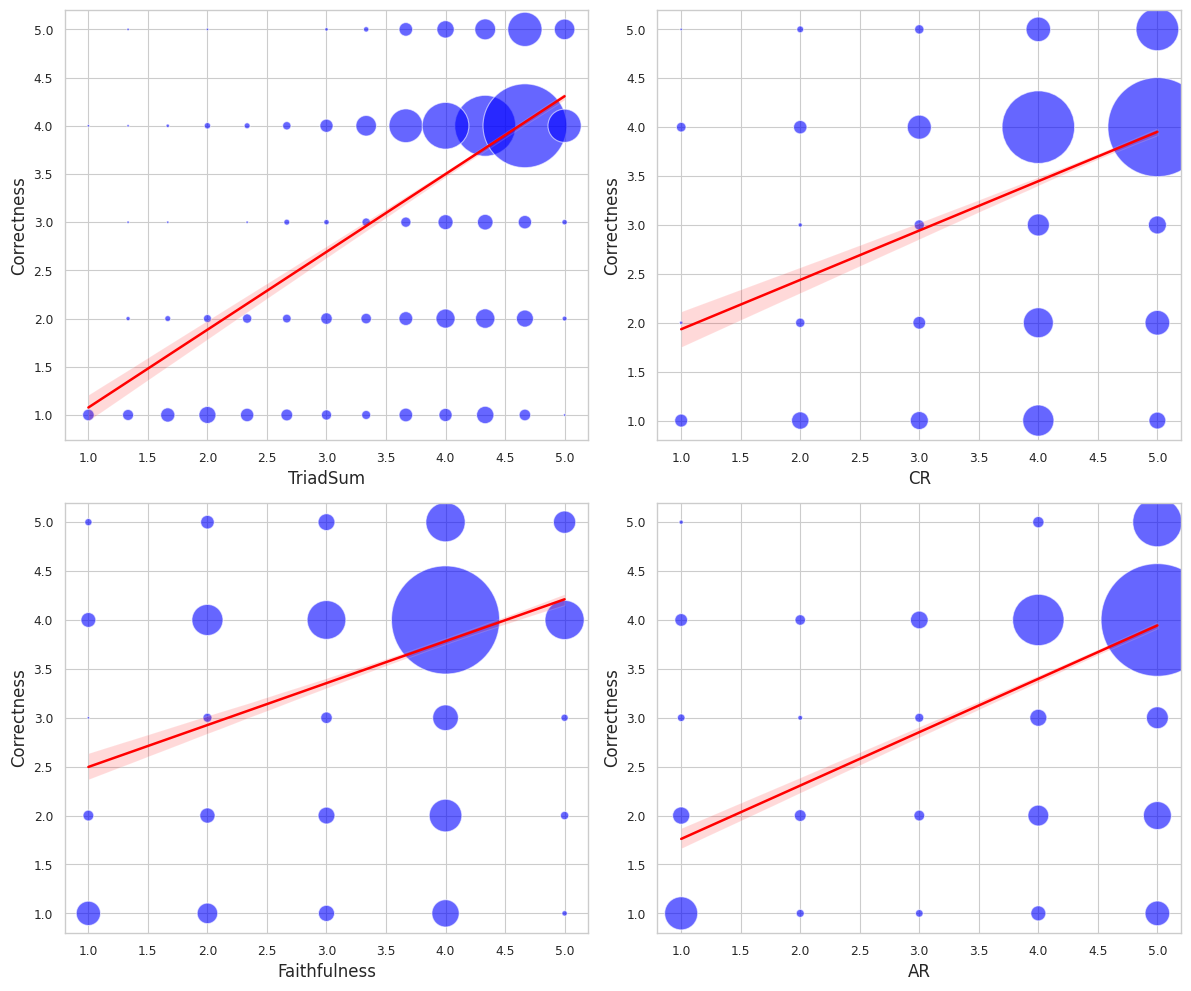

In [59]:
# Set Style
sns.set_theme(style="whitegrid", font_scale=1.5)
sns.set_palette("viridis")  # Suitable for colorblind readers
sns.color_palette("muted")    # Balanced colors
sns.set_context("paper")


# Get eval results file names
eval_results_dir = "../eval_results/triad"
eval_results_file_names = get_csv_files_from_dir(eval_results_dir)

# Loop over all eval results files and output the filenames with an index in the dir
for filename in eval_results_file_names[3:4]:  # Iterate over all eval results files
    # Filter files: Only look at files with quExp1_rerank1_cExp*_backRevFalse_numRef4
    # first_file = f"{eval_results_dir}/{eval_results_file_names[1]}"  # Slice for dev
    file = eval_results_dir + "/" + filename  # Slice for dev
    print(f"File: {file}")
    # Read eval results from CSV
    eval_results_df = pd.read_csv(file)
    # Get first 10 rows 
    # eval_results_df = eval_results_df.head(10)
    # print(f"Eval results: {eval_results_df.head()}")
    eval_results_df = add_triad_column(df=eval_results_df,combination="high")


    # print(f" eval results columns: {eval_results_df.columns}")    
    eval_results_df[["answer",'ground_truth',"TriadSum","CR","Faithfulness","AR", "Correct"]]
    corr_matrix = eval_results_df[["TriadSum","CR","Faithfulness","AR", "Correct"]].corr("pearson")
    print(corr_matrix)


##
## Examine correlation between TriadSum and Correct
## 

# Heatmap
cmap = sns.diverging_palette(220, 20, as_cmap=True)  # 220 for blue, 20 for red
sns.heatmap(corr_matrix, annot=True, fmt='.2f', linewidths=0.5)
plt.savefig(f"../plots/corr_matrix_test.pdf",format="pdf")
plt.show()
##


# Pair plot to visualize relationships between variables
#sns.pairplot(eval_results_df[['TriadSum','CR','Faithfulness','AR','Correct']])
# plt.suptitle('Pair Plot of Variables', y=1.02)

#plt.savefig(f"../plots/pair_plot_test.pdf",format="pdf")
#plt.show()
##


# Scatterplot with regression line
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

for i, col in enumerate(['TriadSum', 'CR', 'Faithfulness', 'AR']):
    sns.regplot(x=eval_results_df[col], y=eval_results_df["Correct"], ax=axes[i], line_kws={"color": "red"})
    axes[i].set_title(f'Scatterplot of {col} vs Correctness')

plt.tight_layout()

plt.savefig(f"../plots/scatter_plot_test.pdf",format="pdf")
plt.show()
##

# Import additional library
from collections import Counter

# Prepare the figure
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

axes = axes.flatten()

for i, col in enumerate(['TriadSum', 'CR', 'Faithfulness', 'AR']):
    # Count the frequency of each data point
    freq = Counter(zip(eval_results_df[col], eval_results_df["Correct"]))
    
    # Extract unique x and y values and their frequencies
    unique_data = list(freq.keys())
    frequencies = list(freq.values())
    
    x_values, y_values = zip(*unique_data)
    
    # Plot scatter with size based on frequency
    scatter = axes[i].scatter(x_values, y_values, s=[f * 3 for f in frequencies], alpha=0.6, edgecolors='w', c='blue')
    
    # Add regression line
    sns.regplot(x=eval_results_df[col], y=eval_results_df["Correct"], ax=axes[i], 
                scatter=False, line_kws={"color": "red"})
    
    
    axes[i].set_xlabel(col,fontsize=12)
    axes[i].set_ylabel('Correctness',fontsize=12)

plt.tight_layout()
plt.savefig(f"../plots/scatter_plot.pdf", format="pdf")
plt.show()

